# ClinVar 遗传突变

## 介绍

在本研究中，使用 ClinVar 遗传突变数据集开发了一个机器学习模型来预测致病性。该数据集经过了彻底的清洗和预处理，包括处理缺失值和删除无关特征。应用了探索性分析技术来获取数据洞察并解决类别不平衡问题。使用特征选择方法来识别最具信息量的特征，并选择了合适的机器学习算法来构建预测模型。该模型为解释遗传突变提供了有价值的工具，有助于遗传疾病的早期检测和个性化治疗。

## 研究问题

### 遗传突变的致病性与遗传疾病分类之间的关系是什么？

In [1]:
# 基础库
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 统计库
from scipy import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy.stats import pearsonr, zscore
%matplotlib inline

# 数据预处理
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# 特征选择
from sklearn.feature_selection import SelectKBest, f_regression

# 模型选择与训练
from sklearn.model_selection import train_test_split, GridSearchCV

# 机器学习模型
from sklearn.linear_model import Lasso
from sklearn.utils import resample

# 评估指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
)

In [2]:

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: d:\Learning_ComputerLanguages\learning_language_python\5_Machine_Learning\2_Experiment


In [3]:
df = pd.read_csv('clinvar_conflicting.csv', low_memory=False)

In [4]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [6]:
df.shape

(65188, 46)

## 数据清洗

上述信息表明，DataFrame总共有 46 个与遗传突变样本相关的参数。如果不进行数据清洗，特征选择和模型生成将非常不准确。

数据清洗通常包括检查空值、检测异常值，以及可视化分类变量和连续变量之间的初步关系。

In [7]:
# 创建一个新的 DataFrame，包含数据类型、缺失值百分比和唯一值数量
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False) # 降序排序

# 为每个变量创建数据类型和标识
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'
    
    # 将获取的值合并到一个新的 DataFrame 'var_df' 中
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)
    
var_df.info()
print(var_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   variable_name        46 non-null     object 
 1   data_type            46 non-null     object 
 2   missing_percentage   46 non-null     float64
 3   flag                 46 non-null     object 
 4   unique_values_count  46 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.9+ KB
         variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1                  POS     int64            0.000000      numeric   
2                  REF    object            0.000000  categorical   
3                  ALT    object            0.000000  categorical   
4               AF_ESP   float64            0.000000      numeric   
5              AF_EXAC   float64            0.000000      numeric   
6            

In [8]:
# 排序
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)

var_df_sorted

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,Consequence,object,0.000000,categorical,48
2,ORIGIN,int64,0.000000,numeric,31
3,IMPACT,object,0.000000,categorical,4
4,CLNVC,object,0.000000,categorical,7
5,CLNHGVS,object,0.000000,categorical,65188
6,CLASS,int64,0.000000,numeric,2
7,CLNDN,object,0.000000,categorical,9260
8,AF_TGP,float64,0.000000,numeric,2087
9,AF_EXAC,float64,0.000000,numeric,6667


上面显示有 9 列的缺失值超过了 99.5%，意味着这些列中实际的非空值少于 0.5%

在本项目中，将删除缺失值超过 99% 的列

In [9]:
var_df = var_df_sorted.copy()

threshold = 99  
var_df = var_df[var_df['missing_percentage'] <= threshold]

var_df

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,Consequence,object,0.000000,categorical,48
2,ORIGIN,int64,0.000000,numeric,31
3,IMPACT,object,0.000000,categorical,4
4,CLNVC,object,0.000000,categorical,7
5,CLNHGVS,object,0.000000,categorical,65188
6,CLASS,int64,0.000000,numeric,2
7,CLNDN,object,0.000000,categorical,9260
8,AF_TGP,float64,0.000000,numeric,2087
9,AF_EXAC,float64,0.000000,numeric,6667


删除这些列后，必须在原始 `df` 中再次删除它们。上面的是从初始数据框中提取的数据框，用于分析。

In [10]:
#  df`中再次删除

threshold = 99  

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist() 

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  CLNVI             27659 non-null  object 
 12  MC                64342 non-null  object 
 13  ORIGIN            65188 non-null  int64  
 14  CLASS             65188 non-null  int64  
 15  Allele            65188 non-null  object 
 16  Consequence       65188 non-null  object

删除了第一批列后，开始检查变量之间的关系，了解数据中的不一致和错误。

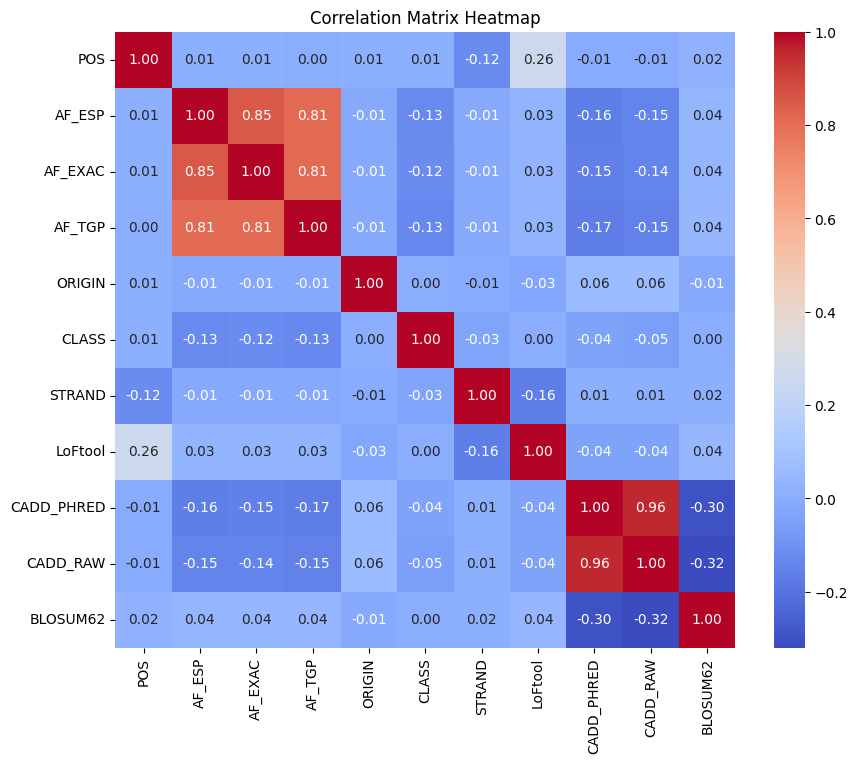

In [11]:
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f') 
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Amino_acids,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,not_specified,NC_000001.10:g.1168180G>C,...,E/D,gaG/gaC,1.0,NaN,tolerated,benign,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",Spinocerebellar_ataxia_21|not_provided,NC_000001.10:g.1470752G>A,...,P/L,cCg/cTg,-1.0,OK,deleterious_low_confidence,benign,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",Strabismus|Nystagmus|Hypothyroidism|Intellectu...,NC_000001.10:g.1737942A>G,...,I/T,aTc/aCc,-1.0,OK,deleterious,probably_damaging,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",Shprintzen-Goldberg_syndrome|not_provided,NC_000001.10:g.2160305G>A,...,G/S,Ggc/Agc,1.0,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",Shprintzen-Goldberg_syndrome,NC_000001.10:g.2160305G>T,...,G/C,Ggc/Tgc,1.0,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


在本项目和实验中，有一些df的列与实验目标无关，或者存在信息冗余，为了提高数据处理效率和简化分析流程，以下列进行删除。理由如下：

1. **`BAM_EDIT`**：  
   - **理由**：二进制比对标识，与基因变异分类无直接关联，属于技术性字段，在本实验中不相关。

2. **`INTRON`**：  
   - **理由**：非空值数量极低，数据缺失率高（86.496%），且包含日期信息，本项目未进行时间序列分析，因此不适用。

3. **`EXON`**：  
   - **理由**：包含日期信息，本实验不涉及时间序列分析，且数据缺失率较高（13.642%），对预测任务无直接贡献。

4. **`CLNDISDB`**：  
   - **理由**：提供 MedGen 数据库标识符，这些标识符在基因变异分类预测中无实际意义，因此可以删除。

5. **`CLNHGVS`**：  
   - **理由**：提供 HGVS 格式的数据库标识符，属于标准化表达，与预测分类任务无关。

6. **`MC`**：  
   - **理由**：与 `Consequence` 列提供的信息重复，同时附带数据库标识符，导致信息冗余。

7. **`CLNVI`**：  
   - **理由**：提供实验室位置信息，与本项目的预测任务无关，因此可以删除。

8. **`SYMBOL`**：  
   - **理由**：基因符号是另一种标识符，功能上与其他字段重复，保留 `Consequence` 即可，删除多余标识符。

9. **`Feature`**：  
   - **理由**：已在 `Consequence` 列中体现，属于信息冗余。

10. **`Feature_type`**：  
    - **理由**：特征类型信息已包含在 `Consequence` 列中，因此可以删除。

11. **`BIOTYPE`**：  
    - **理由**：生物类型信息已在 `Consequence` 列中体现，属于冗余信息。

12. **`CADD_RAW`**：  
    - **理由**：与 `CADD_PHRED` 直接相关，`CADD_PHRED` 提供了更易于解释的标准化分数，因此保留 `CADD_PHRED` 即可。

In [13]:
df.drop(['BAM_EDIT', 'EXON', 'CLNDISDB', 'CLNHGVS', 
         'MC', 'CLNVI', 'SYMBOL', 'Feature', 'Feature_type', 
         'BIOTYPE', 'INTRON', 'CADD_RAW'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     56304 non-null  object 
 15  CDS_position      55233 non-null  object 
 16  Protein_position  55233 non-null  object

In [14]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POS         65188 non-null  int64  
 1   AF_ESP      65188 non-null  float64
 2   AF_EXAC     65188 non-null  float64
 3   AF_TGP      65188 non-null  float64
 4   ORIGIN      65188 non-null  int64  
 5   CLASS       65188 non-null  int64  
 6   STRAND      65174 non-null  float64
 7   LoFtool     60975 non-null  float64
 8   CADD_PHRED  64096 non-null  float64
 9   CADD_RAW    64096 non-null  float64
 10  BLOSUM62    25593 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 5.5 MB


In [15]:
numerical_columns.head()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,CLASS,STRAND,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1168180,0.0771,0.10020,0.1066,1,0,1.0,NaN,1.053,-0.208682,2.0
1,1470752,0.0000,0.00000,0.0000,1,0,-1.0,NaN,31.000,6.517838,-3.0
2,1737942,0.0000,0.00001,0.0000,35,1,-1.0,NaN,28.100,6.061752,-1.0
3,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,22.500,3.114491,NaN
4,2160305,0.0000,0.00000,0.0000,33,0,1.0,NaN,24.700,4.766224,-3.0


In [16]:
object_cols = df.select_dtypes(include=['object'])
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CHROM             65188 non-null  object
 1   REF               65188 non-null  object
 2   ALT               65188 non-null  object
 3   CLNDN             65188 non-null  object
 4   CLNVC             65188 non-null  object
 5   Allele            65188 non-null  object
 6   Consequence       65188 non-null  object
 7   IMPACT            65188 non-null  object
 8   cDNA_position     56304 non-null  object
 9   CDS_position      55233 non-null  object
 10  Protein_position  55233 non-null  object
 11  Amino_acids       55184 non-null  object
 12  Codons            55184 non-null  object
 13  SIFT              24836 non-null  object
 14  PolyPhen          24796 non-null  object
dtypes: object(15)
memory usage: 7.5+ MB


In [17]:
object_cols.head()

,CHROM,REF,ALT,CLNDN,CLNVC,Allele,Consequence,IMPACT,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,SIFT,PolyPhen
0,1,G,C,not_specified,single_nucleotide_variant,C,missense_variant,MODERATE,552,522,174,E/D,gaG/gaC,tolerated,benign
1,1,G,A,Spinocerebellar_ataxia_21|not_provided,single_nucleotide_variant,A,missense_variant,MODERATE,523,509,170,P/L,cCg/cTg,deleterious_low_confidence,benign
2,1,A,G,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,single_nucleotide_variant,G,missense_variant,MODERATE,632,239,80,I/T,aTc/aCc,deleterious,probably_damaging
3,1,G,A,Shprintzen-Goldberg_syndrome|not_provided,single_nucleotide_variant,A,missense_variant,MODERATE,132,100,34,G/S,Ggc/Agc,NaN,NaN
4,1,G,T,Shprintzen-Goldberg_syndrome,single_nucleotide_variant,T,missense_variant,MODERATE,132,100,34,G/C,Ggc/Tgc,NaN,NaN


将对象类型列和数值列分开进行初步可视化。仍然存在一些错误，将根据需要处理。

In [18]:
still_missing = pd.DataFrame()

for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("仍然缺失的Columns:")
still_missing.info()

仍然缺失的Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     56304 non-null  object 
 1   CDS_position      55233 non-null  object 
 2   Protein_position  55233 non-null  object 
 3   Amino_acids       55184 non-null  object 
 4   Codons            55184 non-null  object 
 5   STRAND            65174 non-null  float64
 6   SIFT              24836 non-null  object 
 7   PolyPhen          24796 non-null  object 
 8   LoFtool           60975 non-null  float64
 9   CADD_PHRED        64096 non-null  float64
 10  BLOSUM62          25593 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [19]:
still_missing.nunique()

cDNA_position       13970
CDS_position        13663
Protein_position     7339
Amino_acids          1262
Codons               2220
STRAND                  2
SIFT                    4
PolyPhen                4
LoFtool              1195
CADD_PHRED           9324
BLOSUM62                6
dtype: int64

In [20]:
for column in still_missing.columns:
    if column == 'BLOSUM62':
        # 使用前向填充（ffill）填充 'BLOSUM62' 列中的缺失值
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'object':
        # 对数据类型为 object 的列使用前向填充（ffill）填充缺失值
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'float64':
        # 对数据类型为 float64 的列插值填充缺失值
        still_missing[column] = still_missing[column].interpolate()

# 使用 0 填充 'LoFtool' 列中的缺失值
still_missing['LoFtool'] = still_missing['LoFtool'].fillna(0)

still_missing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     65188 non-null  object 
 1   CDS_position      65188 non-null  object 
 2   Protein_position  65188 non-null  object 
 3   Amino_acids       65188 non-null  object 
 4   Codons            65188 non-null  object 
 5   STRAND            65188 non-null  float64
 6   SIFT              65188 non-null  object 
 7   PolyPhen          65188 non-null  object 
 8   LoFtool           65188 non-null  float64
 9   CADD_PHRED        65188 non-null  float64
 10  BLOSUM62          65188 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [21]:
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     65188 non-null  object 
 15  CDS_position      65188 non-null  object 
 16  Protein_position  65188 non-null  object

In [22]:
df_original = df.copy()

所有空值已填充完成。进行可视化异常值分布。

In [23]:
label_encoder = LabelEncoder()

# 可视化必须将df转换
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

In [24]:
for column in df.columns:
    if df[column].dtype == 'int32':
        df[column] = df[column].astype('int64')

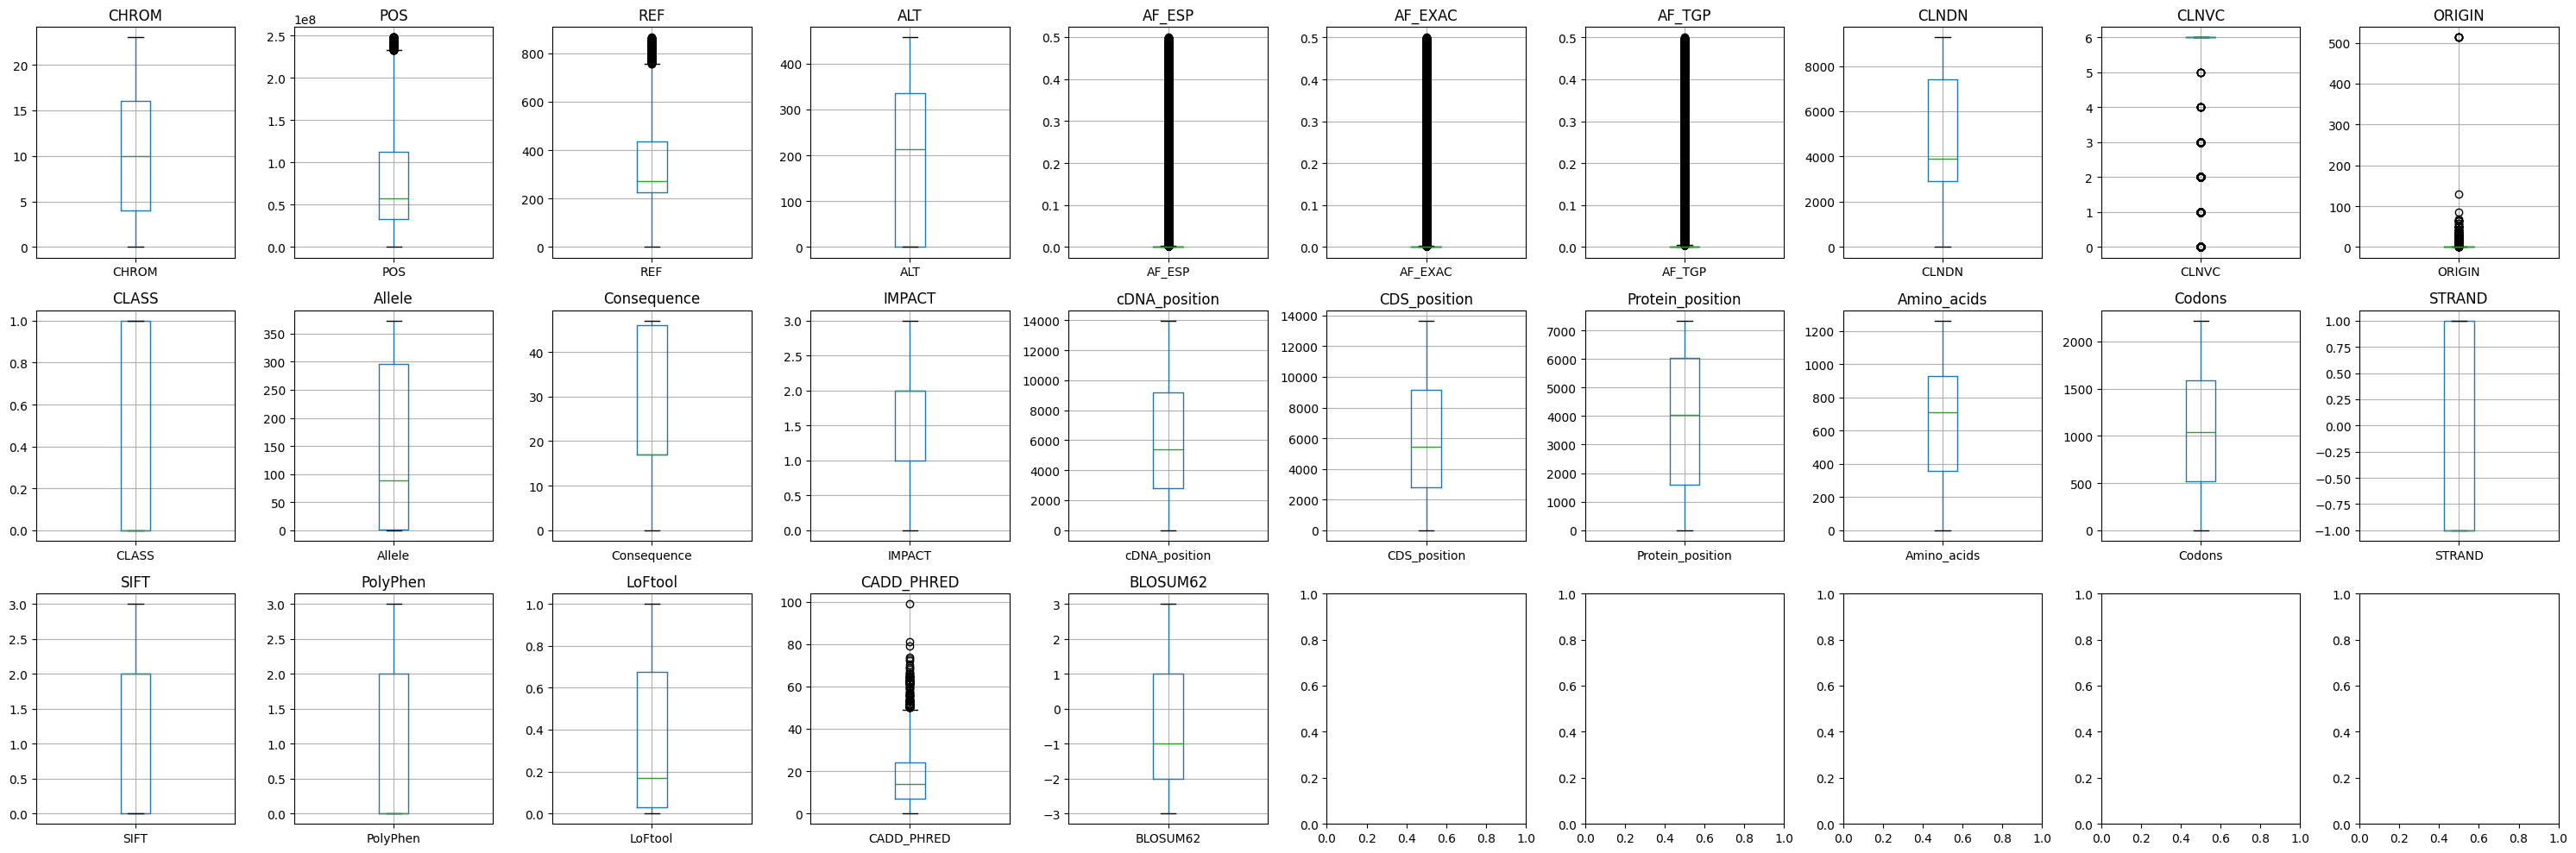

In [25]:
num_columns = 10  # 每行5个子图
num_rows = (len(df.columns) - 1) // num_columns + 1  # 根据列数计算所需的行数

# 创建子图
fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 10))


for i, column in enumerate(df.columns):
    row = i // num_columns 
    col = i % num_columns   
    ax = axes[row][col]     
    df.boxplot(column=column, ax=ax)  
    ax.set_title(column)    

# 调整布局并显示图表
plt.tight_layout()
plt.show()

上方箱线图显示了某些列存在显著的异常值。特别是三个等位基因频率列（AF_ESP、AF_EXAC、AF_TGP）异常严重。根据相关性热力图，这些列彼此之间以及与其他变量之间具有较高的相关性。这些特征可能对模型有益或有害。

等位基因频率对研究人群遗传学和基因组学非常有用，可帮助了解特定变异在不同人群中的分布和影响。每列等位基因频率分别来自不同的来源：

1. **AF_ESP**：来自 NHLBI 外显子测序项目。
2. **AF_EXAC**：来自 Exome Aggregation Consortium。
3. **AF_TGP**：来自 1000 基因组计划。

## 数据探索性分析

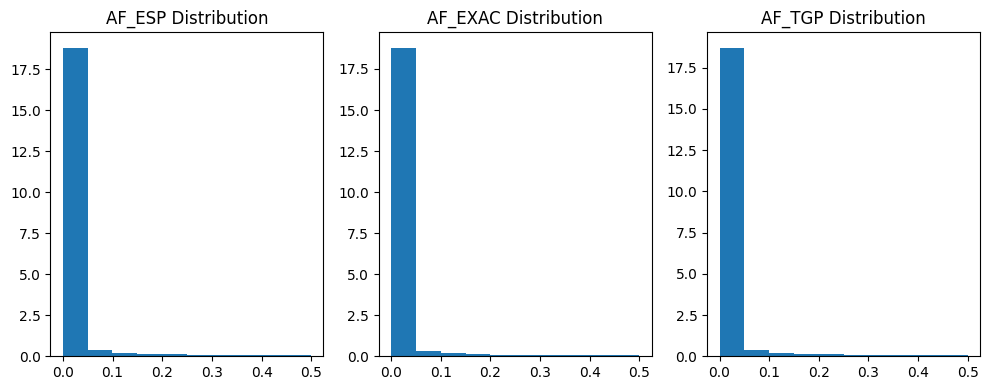

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))


ax1.hist(df['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')


ax2.hist(df['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')


ax3.hist(df['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()

plt.show()

等位基因频率分布显示出相似的右偏态分布。结合 0% 的缺失值和高相关性，这些列之间并无显著差异。

然而，这些列的缺失值被标记为 "0"，Python 在迭代时将其计为非空值。因此，需要进一步探查这些 "0" 是否真正表示缺失值。

In [27]:
allele_df = df[['AF_ESP', 'AF_EXAC', 'AF_TGP']]
allele_df.info()


esp_zeros = 0
exac_zeros = 0
tgp_zeros = 0


for column in allele_df.columns:
    column_values = allele_df[column].values
    zeros_count = len(column_values[column_values == 0])
    
    if column == 'AF_ESP':
        esp_zeros += zeros_count
    elif column == 'AF_EXAC':
        exac_zeros += zeros_count
    elif column == 'AF_TGP':
        tgp_zeros += zeros_count

print("AF_ESP 列中零值（缺失值）的数量:", esp_zeros)
print("AF_EXAC 列中零值（缺失值）的数量:", exac_zeros)
print("AF_TGP 列中零值（缺失值）的数量:", tgp_zeros)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   65188 non-null  float64
 1   AF_EXAC  65188 non-null  float64
 2   AF_TGP   65188 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB
AF_ESP 列中零值（缺失值）的数量: 35781
AF_EXAC 列中零值（缺失值）的数量: 24047
AF_TGP 列中零值（缺失值）的数量: 37972


In [28]:
esp_missing = round((esp_zeros / len(allele_df)) * 100, 2)
exac_missing = round((exac_zeros / len(allele_df)) * 100, 2)
tgp_missing = round((tgp_zeros / len(allele_df)) * 100, 2)

print("AF_ESP 列实际缺失值的百分比:", esp_missing)
print("AF_EXAC 列实际缺失值的百分比:", exac_missing)
print("AF_TGP 列实际缺失值的百分比:", tgp_missing)

AF_ESP 列实际缺失值的百分比: 54.89
AF_EXAC 列实际缺失值的百分比: 36.89
AF_TGP 列实际缺失值的百分比: 58.25


这三列的零值数量各不相同。ESP 和 TGP 的缺失百分比分别为 54.89% 和 58.25%，而 EXAC 仅为 36.89%。EXAC 似乎更全面。

**然而，关联不等于因果关系，需要进一步验证。**

In [29]:
for column in allele_df.columns:
    allele_df.loc[allele_df[column] == 0, column] = None

allele_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   29407 non-null  float64
 1   AF_EXAC  41141 non-null  float64
 2   AF_TGP   27216 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


`allele_df` 数据框现在包含了每列的正确非空值计数。

In [30]:
# 定义用于填充缺失值的方法
methods = ['mean', 'median', 'interpolation']

# 计算原始 DataFrame 的偏度和峰度
original_skewness = allele_df.skew()  # 计算原始数据的偏度
original_kurtosis = allele_df.kurtosis()  # 计算原始数据的峰度

results = {}

# 遍历所有填充方法
for method in methods:
    if method == 'mean':
        filled_df = allele_df.fillna(allele_df.mean())  # 使用均值填充
    elif method == 'median':
        filled_df = allele_df.fillna(allele_df.median())  # 使用中位数填充
    elif method == 'interpolation':
        filled_df = allele_df.interpolate()  # 使用插值法填充
    
    # 计算填充后的偏度和峰度
    skewness = filled_df.skew()
    kurtosis = filled_df.kurtosis()
    
    results[method] = {'skewness': skewness, 'kurtosis': kurtosis}

for method in methods:
    print(f"使用 {method.capitalize()} 填充缺失值的 DataFrame：")
    print("偏度:\n", results[method]['skewness'])
    print("峰度:\n", results[method]['kurtosis'])
    print()


使用 Mean 填充缺失值的 DataFrame：
偏度:
 AF_ESP     5.202084
AF_EXAC    5.298650
AF_TGP     5.019229
dtype: float64
峰度:
 AF_ESP     30.898066
AF_EXAC    30.640676
AF_TGP     29.132435
dtype: float64

使用 Median 填充缺失值的 DataFrame：
偏度:
 AF_ESP     5.487124
AF_EXAC    5.438034
AF_TGP     5.360450
dtype: float64
峰度:
 AF_ESP     32.284693
AF_EXAC    31.367908
AF_TGP     30.756773
dtype: float64

使用 Interpolation 填充缺失值的 DataFrame：
偏度:
 AF_ESP     4.116734
AF_EXAC    4.615365
AF_TGP     3.776132
dtype: float64
峰度:
 AF_ESP     18.511210
AF_EXAC    22.881498
AF_TGP     15.487232
dtype: float64



上方运用了三种填充缺失值方法的偏度和峰度。插值法在数据上引入了最小的偏度和峰度。

因此，在本项目的后续处理中，所有三列都将使用插值法来填充缺失值。


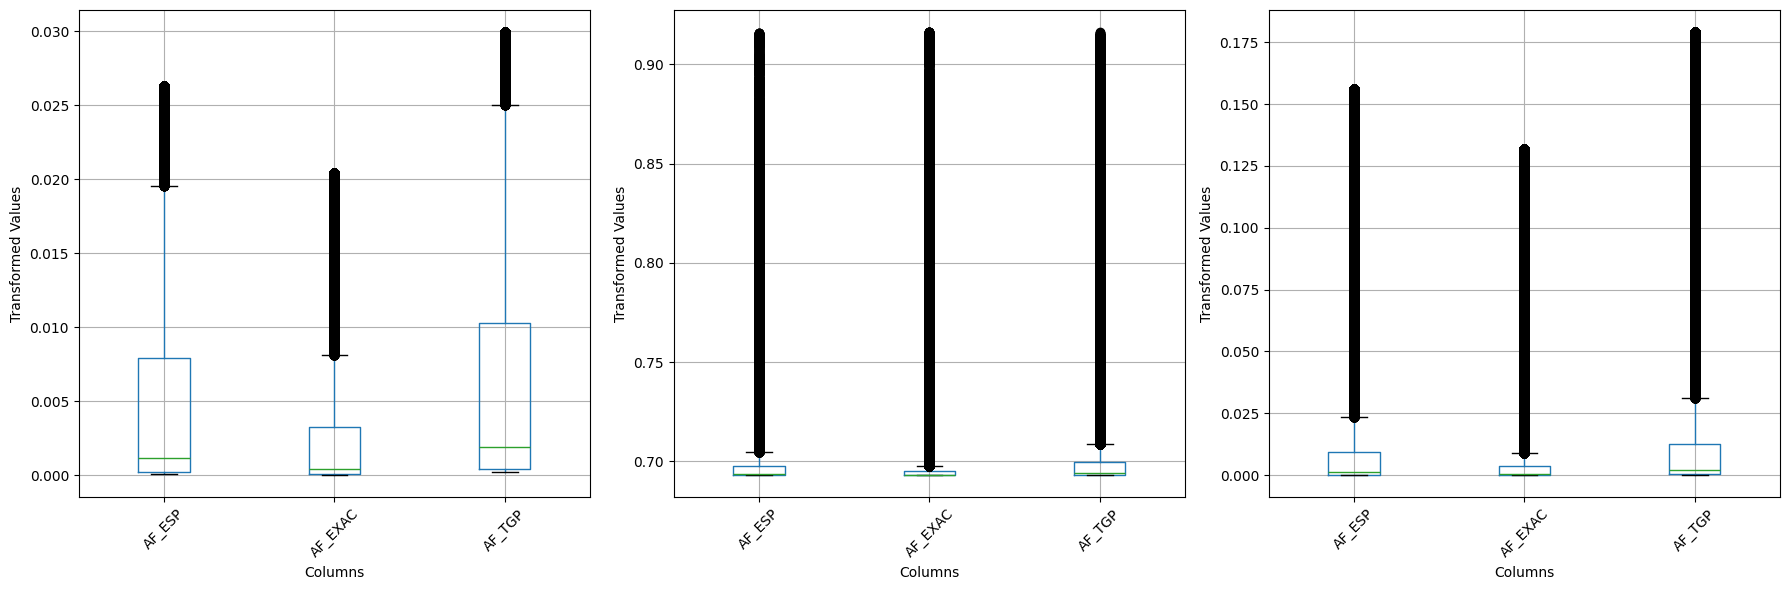

In [31]:
# 使用插值法填充缺失值
allele_df = allele_df.interpolate()

# 对 DataFrame 应用 Box-Cox 变换
allele_df_boxcox = allele_df.copy()
for column in allele_df_boxcox.columns:
    transformed_data, _ = boxcox(allele_df_boxcox[column].dropna() + 1)  # 加 1 以避免零值
    allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data

# 对 DataFrame 进行对数变换
log_constant = 1
allele_df_log = np.log1p(allele_df + log_constant)

# 对 DataFrame 应用 Winsorization 变换
allele_df_winsorized = allele_df.copy()
for column in allele_df_winsorized.columns:
    allele_df_winsorized[column] = winsorize(allele_df_winsorized[column].dropna(), limits=[0.05, 0.05])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Box-Cox 转换后的箱线图
allele_df_boxcox.boxplot(ax=axes[0])
axes[0].set_xticklabels(allele_df_boxcox.columns, rotation=45)
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Transformed Values")

# 对数变换后的箱线图
allele_df_log.boxplot(ax=axes[1])
axes[1].set_xticklabels(allele_df_log.columns, rotation=45)
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Transformed Values")

# Winsorization 转换后的箱线图
allele_df_winsorized.boxplot(ax=axes[2])
axes[2].set_xticklabels(allele_df_winsorized.columns, rotation=45)
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Transformed Values")

plt.tight_layout()

plt.show()


从箱线图的表现来看，Box-Cox 变换对三列的异常值处理效果最好。现在让我们更新dataframe。

In [32]:
df.update(allele_df_boxcox)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

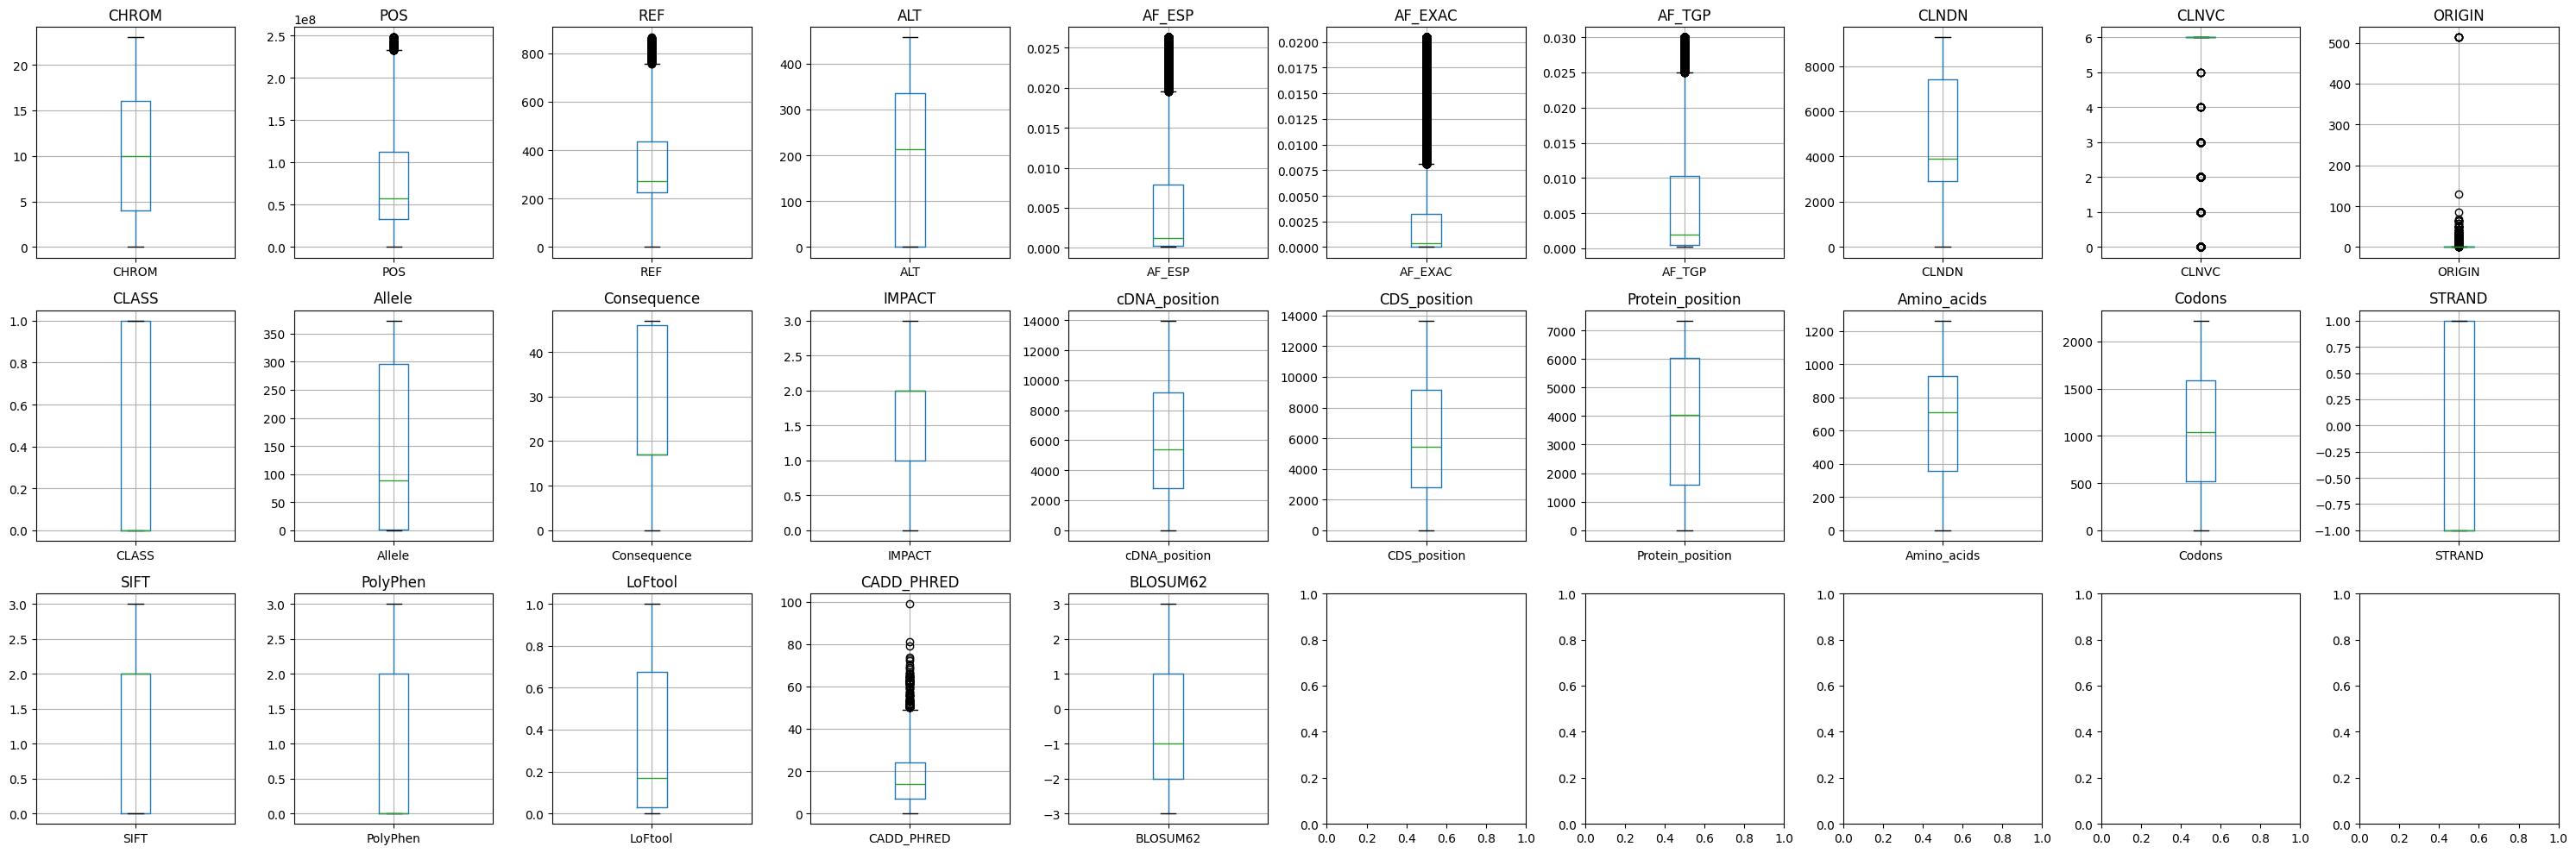

In [33]:
num_columns = 10
num_rows = (len(df.columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(30, 10))

for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [34]:
z_scores = df.apply(stats.zscore)

# 使用 z 分数阈值识别异常值
z_score_threshold = 3  
# 计算每一列中异常值的数量
num_outliers = (np.abs(z_scores) > z_score_threshold).sum()

print("异常值数量:")
print(num_outliers)


异常值数量:
CHROM                  0
POS                    0
REF                    0
ALT                    0
AF_ESP                 0
AF_EXAC                0
AF_TGP                 0
CLNDN                  0
CLNVC               3543
ORIGIN               416
CLASS                  0
Allele                 0
Consequence            0
IMPACT                 0
cDNA_position          0
CDS_position           0
Protein_position       0
Amino_acids            0
Codons                 0
STRAND                 0
SIFT                   0
PolyPhen               0
LoFtool                0
CADD_PHRED           155
BLOSUM62               0
dtype: int64


到此为止，已成功处理了异常值，仍然有 3 列存在 z-score 大于 3 的异常值。

目前暂时保持这些列不变。

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

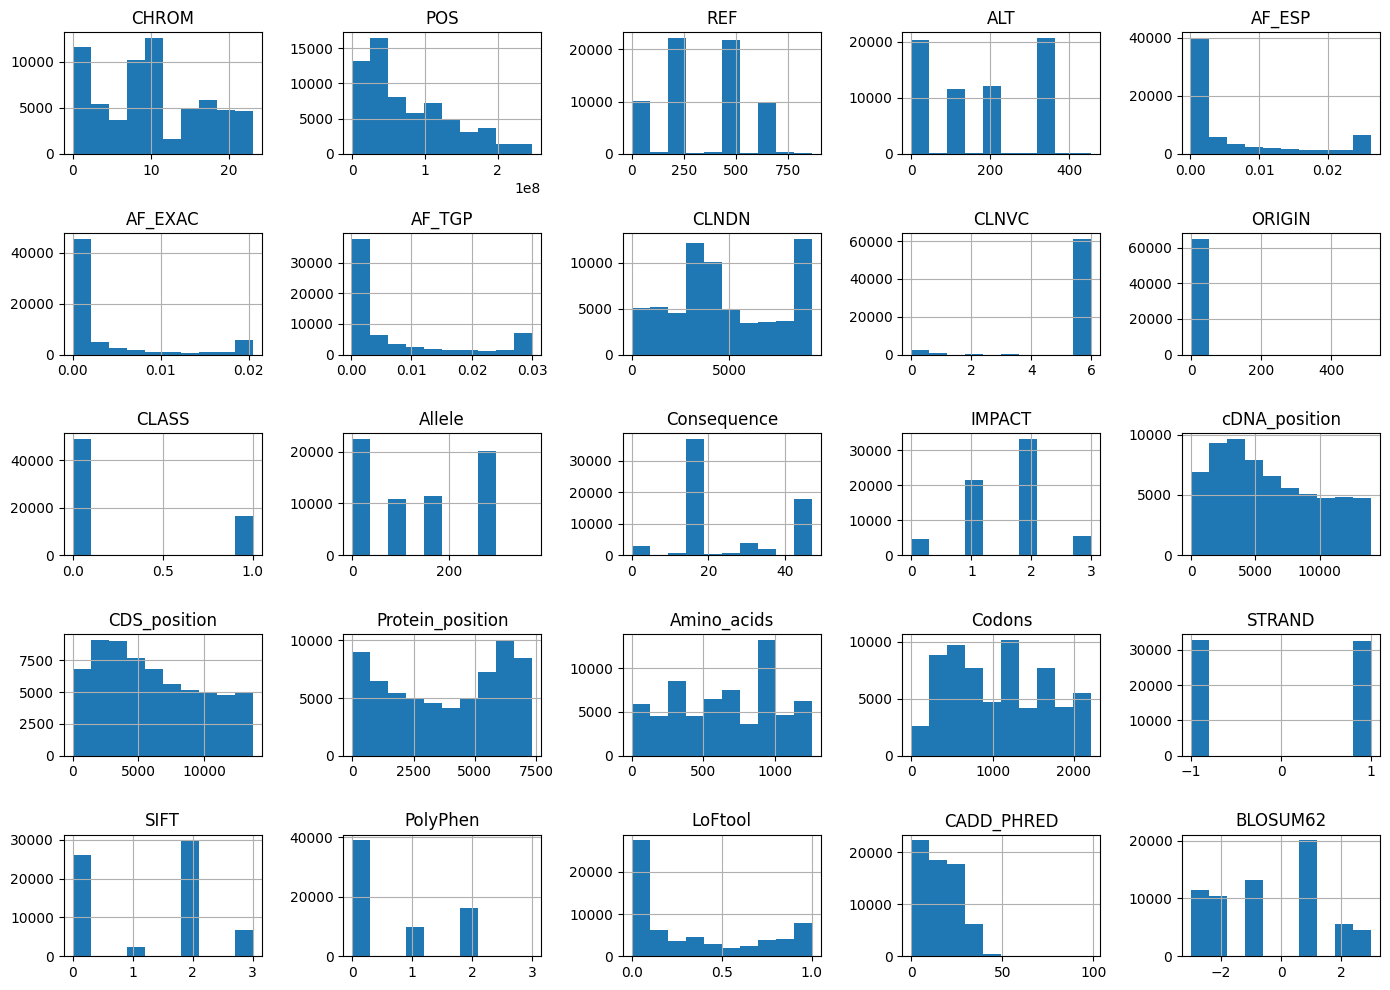

In [36]:
# 绘制所有列的直方图
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

In [37]:
# 需要时进行运行，此处进行注释

# # 单另画出每一个上面的图像
# for column in df.columns:
#     plt.figure(figsize=(8, 6))
#     plt.hist(df[column])
#     plt.title(f"Histogram of {column}")
#     plt.xlabel("Value")
#     plt.ylabel("Frequency")
#     plt.show()

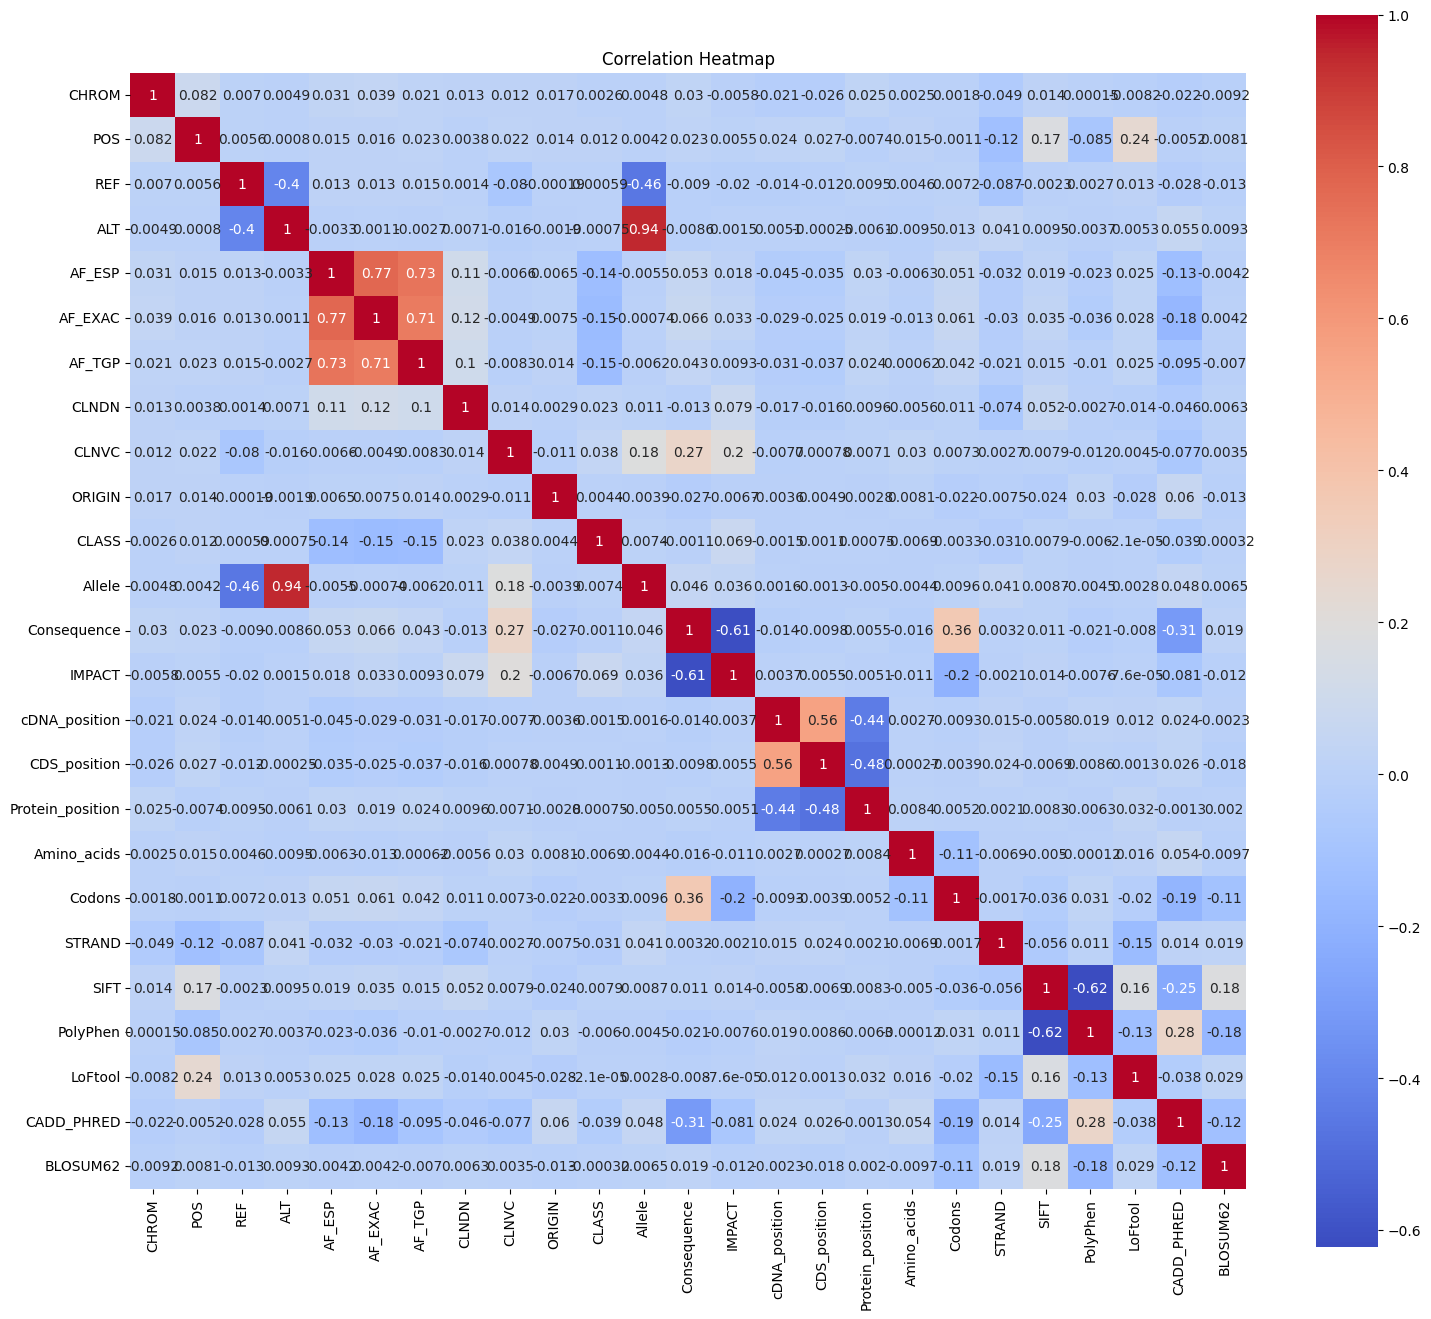

In [38]:
plt.figure(figsize=(18, 16))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

我们现在对清洗后的数据有了更深入的了解。上方的相关性热力图显示，一些变量之间存在很高的相关性。这对模型来说既可能是好事，也可能是坏事。目标变量与特征之间的高相关性可能意味着这些变量是良好的预测因子，也可能表示存在多重共线性问题。

接下来我们将探讨这一点，并引入**特征工程**和**特征选择**。

In [39]:
corr_matrix = df.corr()
correlation_pairs = []

# 遍历矩阵
for i, column1 in enumerate(corr_matrix.columns):
    for j, column2 in enumerate(corr_matrix.columns):
        if i != j:
            correlation = abs(corr_matrix[column1][column2])  # 计算相关系数的绝对值
            correlation_pairs.append((column1, column2, correlation))

# 按相关系数的绝对值降序排序
correlation_pairs.sort(key=lambda x: x[2], reverse=True)

# 打印排序后的相关系数对
for pair in correlation_pairs:
    column1, column2, correlation = pair
    print(f"{column1} 和 {column2} 之间的绝对相关系数: {correlation:.2f}")


ALT 和 Allele 之间的绝对相关系数: 0.94
Allele 和 ALT 之间的绝对相关系数: 0.94
AF_ESP 和 AF_EXAC 之间的绝对相关系数: 0.77
AF_EXAC 和 AF_ESP 之间的绝对相关系数: 0.77
AF_ESP 和 AF_TGP 之间的绝对相关系数: 0.73
AF_TGP 和 AF_ESP 之间的绝对相关系数: 0.73
AF_EXAC 和 AF_TGP 之间的绝对相关系数: 0.71
AF_TGP 和 AF_EXAC 之间的绝对相关系数: 0.71
SIFT 和 PolyPhen 之间的绝对相关系数: 0.62
PolyPhen 和 SIFT 之间的绝对相关系数: 0.62
Consequence 和 IMPACT 之间的绝对相关系数: 0.61
IMPACT 和 Consequence 之间的绝对相关系数: 0.61
cDNA_position 和 CDS_position 之间的绝对相关系数: 0.56
CDS_position 和 cDNA_position 之间的绝对相关系数: 0.56
CDS_position 和 Protein_position 之间的绝对相关系数: 0.48
Protein_position 和 CDS_position 之间的绝对相关系数: 0.48
REF 和 Allele 之间的绝对相关系数: 0.46
Allele 和 REF 之间的绝对相关系数: 0.46
cDNA_position 和 Protein_position 之间的绝对相关系数: 0.44
Protein_position 和 cDNA_position 之间的绝对相关系数: 0.44
REF 和 ALT 之间的绝对相关系数: 0.40
ALT 和 REF 之间的绝对相关系数: 0.40
Consequence 和 Codons 之间的绝对相关系数: 0.36
Codons 和 Consequence 之间的绝对相关系数: 0.36
Consequence 和 CADD_PHRED 之间的绝对相关系数: 0.31
CADD_PHRED 和 Consequence 之间的绝对相关系数: 0.31
PolyPhen 和 CADD_PHRED 之间的绝对相关系数: 0.28
CADD_PHRED 和 PolyPhe

In [40]:
# 筛选绝对值大于 0.10 的相关系数
corr_matrix = df.corr()

for column1 in corr_matrix.columns:
    for column2 in corr_matrix.columns:
        if column1 != column2:  # 排除相同列之间的比较
            correlation = corr_matrix[column1][column2]  # 获取相关系数
            if abs(correlation) > 0.10:  
                print(f"{column1} 和 {column2} 之间的相关系数: {correlation:.2f}")


POS 和 STRAND 之间的相关系数: -0.12
POS 和 SIFT 之间的相关系数: 0.17
POS 和 LoFtool 之间的相关系数: 0.24
REF 和 ALT 之间的相关系数: -0.40
REF 和 Allele 之间的相关系数: -0.46
ALT 和 REF 之间的相关系数: -0.40
ALT 和 Allele 之间的相关系数: 0.94
AF_ESP 和 AF_EXAC 之间的相关系数: 0.77
AF_ESP 和 AF_TGP 之间的相关系数: 0.73
AF_ESP 和 CLNDN 之间的相关系数: 0.11
AF_ESP 和 CLASS 之间的相关系数: -0.14
AF_ESP 和 CADD_PHRED 之间的相关系数: -0.13
AF_EXAC 和 AF_ESP 之间的相关系数: 0.77
AF_EXAC 和 AF_TGP 之间的相关系数: 0.71
AF_EXAC 和 CLNDN 之间的相关系数: 0.12
AF_EXAC 和 CLASS 之间的相关系数: -0.15
AF_EXAC 和 CADD_PHRED 之间的相关系数: -0.18
AF_TGP 和 AF_ESP 之间的相关系数: 0.73
AF_TGP 和 AF_EXAC 之间的相关系数: 0.71
AF_TGP 和 CLNDN 之间的相关系数: 0.10
AF_TGP 和 CLASS 之间的相关系数: -0.15
CLNDN 和 AF_ESP 之间的相关系数: 0.11
CLNDN 和 AF_EXAC 之间的相关系数: 0.12
CLNDN 和 AF_TGP 之间的相关系数: 0.10
CLNVC 和 Allele 之间的相关系数: 0.18
CLNVC 和 Consequence 之间的相关系数: 0.27
CLNVC 和 IMPACT 之间的相关系数: 0.20
CLASS 和 AF_ESP 之间的相关系数: -0.14
CLASS 和 AF_EXAC 之间的相关系数: -0.15
CLASS 和 AF_TGP 之间的相关系数: -0.15
Allele 和 REF 之间的相关系数: -0.46
Allele 和 ALT 之间的相关系数: 0.94
Allele 和 CLNVC 之间的相关系数: 0.18
Consequence 和 CLNVC 之间的相关

In [41]:
# 筛选绝对值大于 0.10 的相关系数，并且根据相关系数绝对值进行从大到小排序 
corr_matrix = df.corr()
correlation_pairs = []

# 遍历相关矩阵
for column1 in corr_matrix.columns:
    for column2 in corr_matrix.columns:
        if column1 != column2:
            correlation = corr_matrix[column1][column2]  
            if abs(correlation) > 0.10: 
                correlation_pairs.append((column1, column2, correlation))

correlation_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for column1, column2, correlation in correlation_pairs:
    print(f"{column1} 和 {column2} 之间的相关系数: {correlation:.2f}")


ALT 和 Allele 之间的相关系数: 0.94
Allele 和 ALT 之间的相关系数: 0.94
AF_ESP 和 AF_EXAC 之间的相关系数: 0.77
AF_EXAC 和 AF_ESP 之间的相关系数: 0.77
AF_ESP 和 AF_TGP 之间的相关系数: 0.73
AF_TGP 和 AF_ESP 之间的相关系数: 0.73
AF_EXAC 和 AF_TGP 之间的相关系数: 0.71
AF_TGP 和 AF_EXAC 之间的相关系数: 0.71
SIFT 和 PolyPhen 之间的相关系数: -0.62
PolyPhen 和 SIFT 之间的相关系数: -0.62
Consequence 和 IMPACT 之间的相关系数: -0.61
IMPACT 和 Consequence 之间的相关系数: -0.61
cDNA_position 和 CDS_position 之间的相关系数: 0.56
CDS_position 和 cDNA_position 之间的相关系数: 0.56
CDS_position 和 Protein_position 之间的相关系数: -0.48
Protein_position 和 CDS_position 之间的相关系数: -0.48
REF 和 Allele 之间的相关系数: -0.46
Allele 和 REF 之间的相关系数: -0.46
cDNA_position 和 Protein_position 之间的相关系数: -0.44
Protein_position 和 cDNA_position 之间的相关系数: -0.44
REF 和 ALT 之间的相关系数: -0.40
ALT 和 REF 之间的相关系数: -0.40
Consequence 和 Codons 之间的相关系数: 0.36
Codons 和 Consequence 之间的相关系数: 0.36
Consequence 和 CADD_PHRED 之间的相关系数: -0.31
CADD_PHRED 和 Consequence 之间的相关系数: -0.31
PolyPhen 和 CADD_PHRED 之间的相关系数: 0.28
CADD_PHRED 和 PolyPhen 之间的相关系数: 0.28
CLNVC 和 Consequence 之间的相

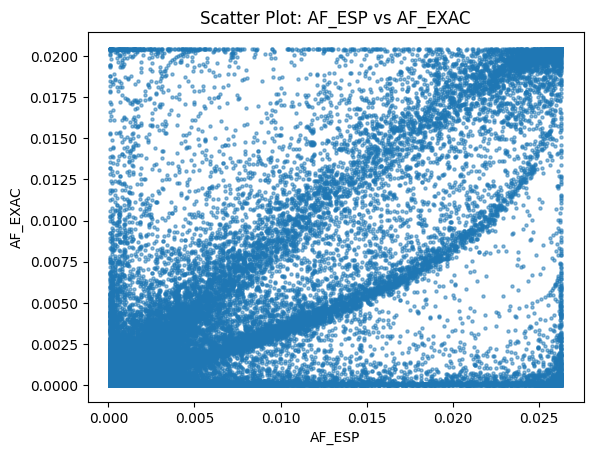

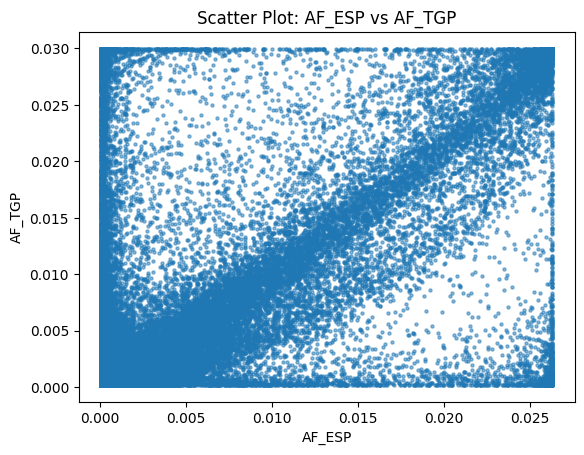

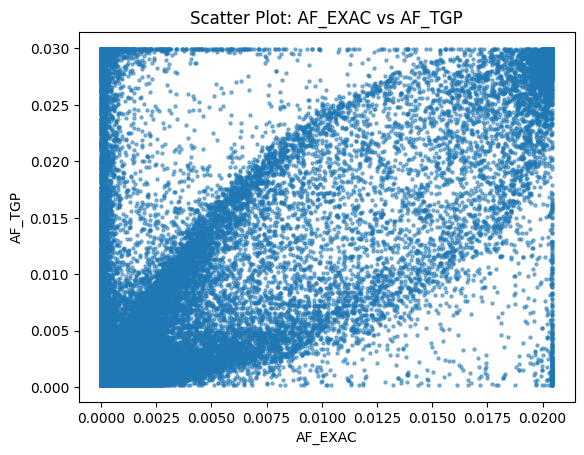

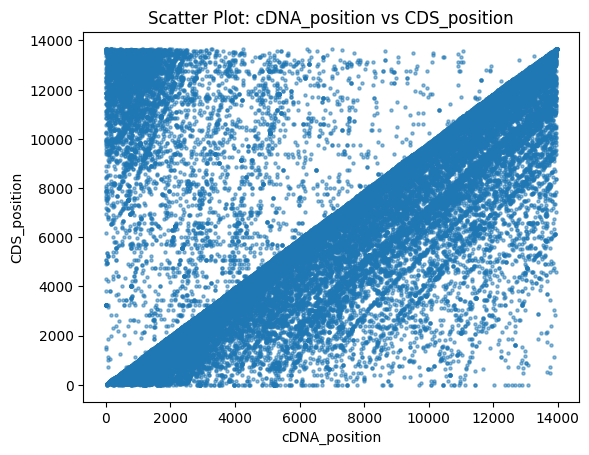

In [42]:
marker_size = 5     # 标记大小
marker_alpha = 0.5  # 标记的透明度

# 绘制 AF_ESP 与 AF_EXAC 的散点图
plt.scatter(df['AF_ESP'], df['AF_EXAC'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_EXAC')
plt.title('Scatter Plot: AF_ESP vs AF_EXAC')
plt.show()

# 绘制 AF_ESP 与 AF_TGP 的散点图
plt.scatter(df['AF_ESP'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_ESP vs AF_TGP')
plt.show()

# 绘制 AF_EXAC 与 AF_TGP 的散点图
plt.scatter(df['AF_EXAC'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_EXAC')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_EXAC vs AF_TGP')
plt.show()

# 绘制 cDNA_position 与 CDS_position 的散点图
plt.scatter(df['cDNA_position'], df['CDS_position'], s=marker_size, alpha=marker_alpha)
plt.xlabel('cDNA_position')
plt.ylabel('CDS_position')
plt.title('Scatter Plot: cDNA_position vs CDS_position')
plt.show()


## 特征选择与模型构建

### 目标：Consequence（后果）

将 `Consequence` 作为第一个目标变量。在数据集中，这个变量将**基因变异**分类为**不同功能后果**，是一个**类别型变量**。

开始探索适合的特征。

In [43]:
# 将 'Consequence' 作为目标变量
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# 确保特征矩阵中所有值非负
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 选择 k 个最佳特征，使用 f_regression 评分函数
k = 10  # 要选择的特征数量
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# 获取被选特征的索引和对应分数
selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.drop('Consequence', axis=1).columns[selected_indices]

# 输出选中的特征和分数
for feature, score in zip(selected_features, selected_scores):
    print(f"特征: {feature}, 分数: {score}")

特征: CHROM, 分数: 57.747722990019355
特征: AF_ESP, 分数: 180.66010059874046
特征: AF_EXAC, 分数: 288.5711145054839
特征: AF_TGP, 分数: 119.59835581759786
特征: CLNVC, 分数: 5231.728110385674
特征: ORIGIN, 分数: 48.29599967965179
特征: Allele, 分数: 137.01186697945053
特征: IMPACT, 分数: 39336.9124367935
特征: Codons, 分数: 9895.459066281754
特征: CADD_PHRED, 分数: 7162.983881252097


In [44]:
df['AF_avg'] = (df['AF_ESP'] + df['AF_EXAC'] + df['AF_TGP']) / 3

In [45]:
corr_class = df[['CHROM', 'AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNVC',
               'Allele', 'IMPACT', 'Codons', 'CADD_PHRED', 'ORIGIN']]
corr_class.corr()

,CHROM,AF_avg,AF_ESP,AF_EXAC,AF_TGP,CLNVC,Allele,IMPACT,Codons,CADD_PHRED,ORIGIN
CHROM,1.000000,0.031852,0.030749,0.039191,0.020878,0.012257,0.004801,-0.005830,0.001816,-0.022239,0.017230
AF_avg,0.031852,1.000000,0.918308,0.883911,0.915775,-0.007514,-0.005020,0.020201,0.054687,-0.140301,0.010665
AF_ESP,0.030749,0.918308,1.000000,0.772039,0.730739,-0.006581,-0.005486,0.017859,0.050631,-0.129133,0.006527
AF_EXAC,0.039191,0.883911,0.772039,1.000000,0.705108,-0.004858,-0.000743,0.033377,0.061006,-0.176864,0.007535
AF_TGP,0.020878,0.915775,0.730739,0.705108,1.000000,-0.008288,-0.006182,0.009260,0.041697,-0.094734,0.013787
CLNVC,0.012257,-0.007514,-0.006581,-0.004858,-0.008288,1.000000,0.183607,0.196429,0.007277,-0.076639,-0.011280
Allele,0.004801,-0.005020,-0.005486,-0.000743,-0.006182,0.183607,1.000000,0.035566,0.009625,0.048116,-0.003889
IMPACT,-0.005830,0.020201,0.017859,0.033377,0.009260,0.196429,0.035566,1.000000,-0.201205,-0.080849,-0.006657
Codons,0.001816,0.054687,0.050631,0.061006,0.041697,0.007277,0.009625,-0.201205,1.000000,-0.186098,-0.021688
CADD_PHRED,-0.022239,-0.140301,-0.129133,-0.176864,-0.094734,-0.076639,0.048116,-0.080849,-0.186098,1.000000,0.059561


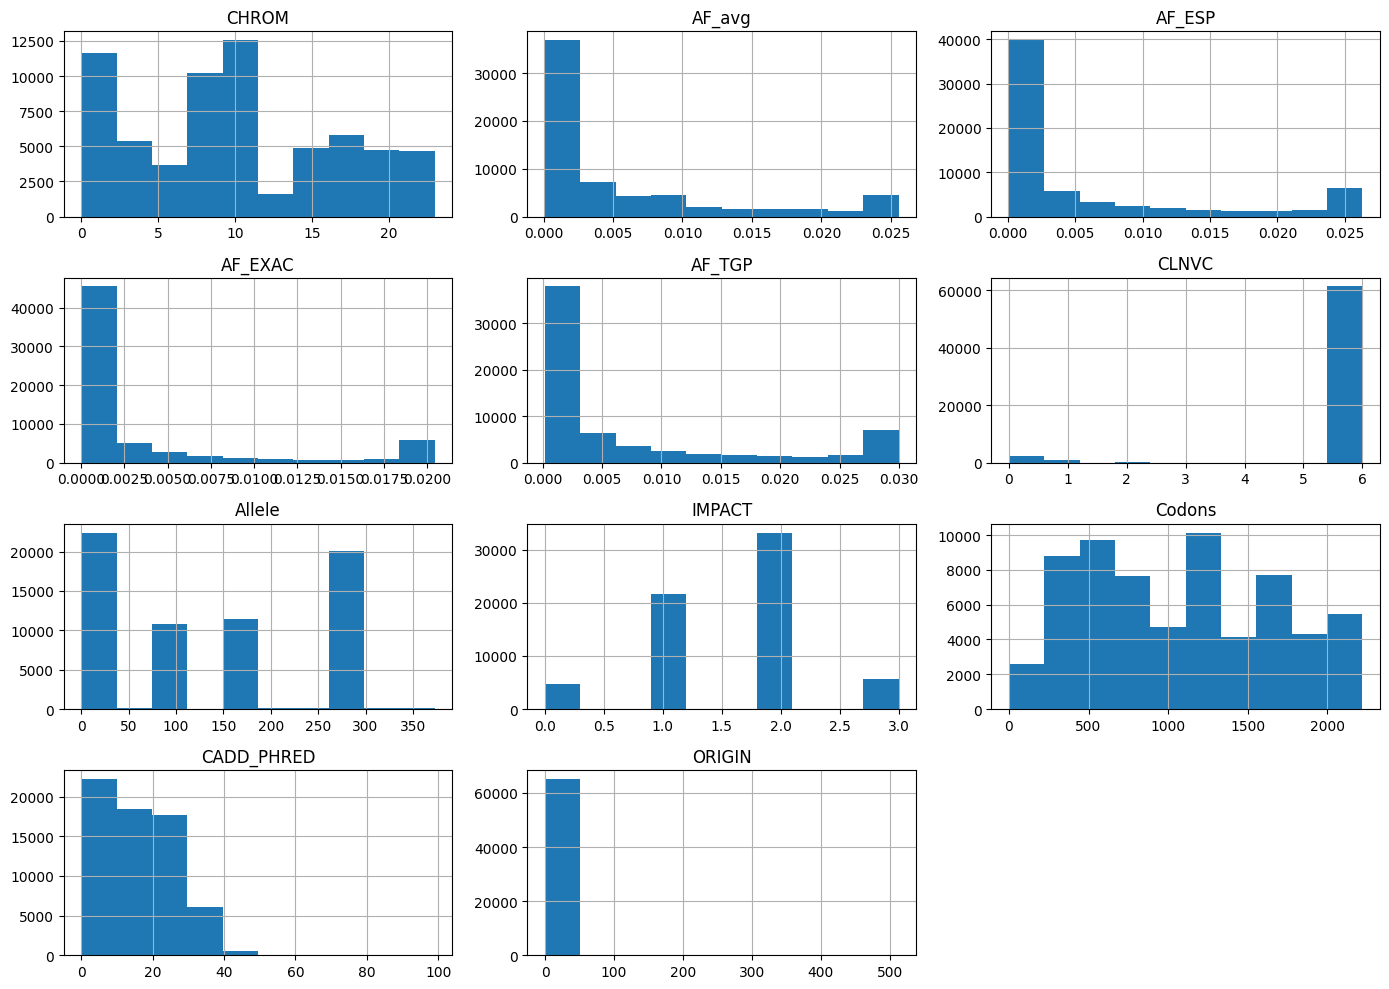

In [46]:
corr_class.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

In [47]:
# 定义评估指标函数
def evaluate_regression(y_true, y_pred):
    """
    计算回归模型的评估指标。

    参数:
    - y_true: 真实值
    - y_pred: 预测值

    返回:
    - 指标字典，包括 MSE、RMSE、MAE、R² 和皮尔逊相关系数
    """
    mse = mean_squared_error(y_true, y_pred)            # 均方误差 (MSE)
    rmse = np.sqrt(mse)                                 # 均方根误差 (RMSE)
    mae = mean_absolute_error(y_true, y_pred)           # 平均绝对误差 (MAE)
    r2 = r2_score(y_true, y_pred)                       # 决定系数 (R²)
    pearson_corr, _ = pearsonr(y_true, y_pred)          # 皮尔逊相关系数

    # 打印评估结果
    print(f"  均方误差 (MSE): {mse:.4f}")
    print(f"  均方根误差 (RMSE): {rmse:.4f}")
    print(f"  平均绝对误差 (MAE): {mae:.4f}")
    print(f"  决定系数 (R²): {r2:.4f}")
    print(f"  皮尔逊相关系数 (Pearson Correlation): {pearson_corr:.4f}\n")

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Pearson Correlation": pearson_corr
}


### Lasso 系数与回归

#### 坐标梯度下降的LASSO求解

In [48]:
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 定义参数网格
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]  # 在 0.00001 到 10 之间搜索 alpha

# 初始化最佳参数和结果
best_alpha = None
best_mse = float('inf')
best_model = None

# 遍历每个 alpha 进行 LASSO 回归训练和评估
for alpha in alphas:
    print(f"Alpha: {alpha}")
    
    # 定义 LASSO 模型
    lasso = Lasso(alpha=alpha, max_iter=1000)
    
    # 拟合模型
    lasso.fit(X_train, y_train)
    
    # 预测
    y_pred = lasso.predict(X_test)
    
    # 评估模型
    metrics = evaluate_regression(y_test, y_pred)
    
    # 更新最佳模型
    if metrics["MSE"] < best_mse:
        best_mse = metrics["MSE"]
        best_alpha = alpha
        best_model = lasso

# 输出最佳模型的结果
print("=== 使用坐标梯度下降法的 LASSO 回归 (网格搜索) ===")
print(f"最佳 alpha: {best_alpha}")
print(f"最佳均方误差 (MSE): {best_mse:.4f}")


Alpha: 1e-05
  均方误差 (MSE): 58.4159
  均方根误差 (RMSE): 7.6430
  平均绝对误差 (MAE): 5.8202
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.0001
  均方误差 (MSE): 58.4156
  均方根误差 (RMSE): 7.6430
  平均绝对误差 (MAE): 5.8202
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.001
  均方误差 (MSE): 58.4149
  均方根误差 (RMSE): 7.6430
  平均绝对误差 (MAE): 5.8203
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.01
  均方误差 (MSE): 58.4129
  均方根误差 (RMSE): 7.6428
  平均绝对误差 (MAE): 5.8216
  决定系数 (R²): 0.6908
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.1
  均方误差 (MSE): 58.5534
  均方根误差 (RMSE): 7.6520
  平均绝对误差 (MAE): 5.8470
  决定系数 (R²): 0.6900
  皮尔逊相关系数 (Pearson Correlation): 0.8309

Alpha: 1
  均方误差 (MSE): 63.7652
  均方根误差 (RMSE): 7.9853
  平均绝对误差 (MAE): 6.2564
  决定系数 (R²): 0.6624
  皮尔逊相关系数 (Pearson Correlation): 0.8250

Alpha: 10
  均方误差 (MSE): 188.8922
  均方根误差 (RMSE): 13.7438
  平均绝对误差 (MAE): 12.4121
  决定系数 (R²): -0.0000
  皮尔逊相关系数 (Pearson Correlation): nan

=== 使用坐标梯度下降法的

手动实现LASSO

In [49]:
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 在特征矩阵中添加一列全1作为截距项
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# 软阈值函数
def soft_thresholding(z, gamma):
    """软阈值函数"""
    return np.sign(z) * max(abs(z) - gamma, 0)

# 坐标梯度下降法求解 LASSO，支持截距项
def lasso_coordinate_descent(X, y, alpha, max_iter=5000, tol=1e-6):
    """坐标梯度下降法求解 LASSO"""
    n, p = X.shape
    beta = np.zeros(p)  # 初始化回归系数为0

    for iteration in range(max_iter):
        beta_old = beta.copy()

        for j in range(p):
            # 计算残差 (y - Xβ + x_j * β_j)
            residual = y - X @ beta + X[:, j] * beta[j]
            rho_j = np.dot(X[:, j], residual) / n

            # 如果是截距项（第0列），不施加正则化
            if j == 0:
                beta[j] = rho_j
            else:
                beta[j] = soft_thresholding(rho_j, alpha / n)

        # 检查收敛条件
        if np.sum(np.abs(beta - beta_old)) < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break

    return beta

# 参数网格
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]  # 在 0.00001 到 10 之间搜索 alpha

# 初始化最佳参数和结果
best_alpha = None
best_mse = float('inf')
best_beta = None

# 网格搜索
for alpha in alphas:
    print(f"Alpha: {alpha}")

    # 使用坐标梯度下降法训练 LASSO
    beta = lasso_coordinate_descent(X_train_bias, y_train, alpha)

    # 预测
    y_pred = X_test_bias @ beta

    # 评估模型
    metrics = evaluate_regression(y_test, y_pred)

    # 更新最佳模型
    if metrics["MSE"] < best_mse:
        best_mse = metrics["MSE"]
        best_alpha = alpha
        best_beta = beta

# 输出最佳结果
print("=== 使用手动实现坐标梯度下降法的 LASSO 回归 (网格搜索) ===")
print(f"最佳 alpha: {best_alpha}")
print(f"最佳均方误差 (MSE): {best_mse:.4f}")


Alpha: 1e-05
  均方误差 (MSE): 58.4205
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.0001
  均方误差 (MSE): 58.4205
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.001
  均方误差 (MSE): 58.4205
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.01
  均方误差 (MSE): 58.4205
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 0.1
  均方误差 (MSE): 58.4205
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 1
  均方误差 (MSE): 58.4204
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Correlation): 0.8311

Alpha: 10
Converged after 4884 iterations.
  均方误差 (MSE): 58.4197
  均方根误差 (RMSE): 7.6433
  平均绝对误差 (MAE): 5.8182
  决定系数 (R²): 0.6907
  皮尔逊相关系数 (Pearson Corr

#### 近端梯度下降的LASSO求解(手动)

In [50]:
# 软阈值函数定义
def soft_thresholding(x, lambda_):
    """软阈值函数"""
    return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)

# 近端梯度下降法求解 LASSO，支持截距项和自适应学习率衰减
def proximal_gradient_descent(X, y, alpha, lr=0.01, decay=0.99, max_iter=5000, tol=1e-6):
    """近端梯度下降法求解 LASSO"""
    m, n = X.shape
    beta = np.zeros(n)       # 初始化系数向量为零
    bias = 0                 # 初始化截距项为零

    for iteration in range(max_iter):
        beta_old = beta.copy()
        bias_old = bias

        # 预测
        y_pred = X.dot(beta) + bias

        # 计算梯度
        gradient = -X.T.dot(y - y_pred) / m
        bias_gradient = -np.sum(y - y_pred) / m

        # 梯度下降更新
        beta -= lr * gradient
        bias -= lr * bias_gradient

        # 软阈值处理（对系数向量进行 LASSO 正则化）
        beta = soft_thresholding(beta, alpha * lr)

        # 判断收敛条件
        if np.linalg.norm(beta - beta_old, ord=2) < tol and abs(bias - bias_old) < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break

        # 学习率衰减
        lr *= decay

    return beta, bias

In [51]:
X = df.drop('Consequence', axis=1).values
y = df['Consequence'].values

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 定义参数网格
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
decays = [1, 0.999, 0.99, 0.95, 0.9, 0.85]  # 学习率衰减参数

# 初始化最佳参数和结果
best_alpha = None
best_decay = None
best_mse = float('inf')
best_beta = None
best_bias = None

# 遍历每个 alpha 和 decay 组合进行 LASSO 回归训练和评估
for alpha in alphas:
    for decay in decays:
        print(f"\nAlpha: {alpha}, Decay: {decay}")

        # 训练手动 LASSO 模型（近端梯度下降法）
        beta, bias = proximal_gradient_descent(X_train, y_train, alpha, lr=0.01, decay=decay)

        # 进行预测
        y_pred = X_test.dot(beta) + bias

        # 评估模型
        metrics = evaluate_regression(y_test, y_pred)

        # 更新最佳模型
        if metrics["MSE"] < best_mse:
            best_mse = metrics["MSE"]
            best_alpha = alpha
            best_decay = decay
            best_beta = beta
            best_bias = bias

# 输出最佳模型的结果
print("\n=== 使用近端梯度下降法的 LASSO 回归 (参数搜索) ===")
print(f"最佳 alpha: {best_alpha}")
print(f"最佳 decay: {best_decay}")
print(f"最佳均方误差 (MSE): {best_mse:.4f}")
print(f"最佳模型系数: {best_beta}")
print(f"最佳模型截距: {best_bias:.4f}")



Alpha: 1e-05, Decay: 1
  均方误差 (MSE): 57.8314
  均方根误差 (RMSE): 7.6047
  平均绝对误差 (MAE): 5.7803
  决定系数 (R²): 0.6937
  皮尔逊相关系数 (Pearson Correlation): 0.8329


Alpha: 1e-05, Decay: 0.999
  均方误差 (MSE): 57.7931
  均方根误差 (RMSE): 7.6022
  平均绝对误差 (MAE): 5.7807
  决定系数 (R²): 0.6939
  皮尔逊相关系数 (Pearson Correlation): 0.8331


Alpha: 1e-05, Decay: 0.99
Converged in 1141 iterations.
  均方误差 (MSE): 167.4973
  均方根误差 (RMSE): 12.9421
  平均绝对误差 (MAE): 10.4385
  决定系数 (R²): 0.1128
  皮尔逊相关系数 (Pearson Correlation): 0.8191


Alpha: 1e-05, Decay: 0.95
Converged in 240 iterations.
  均方误差 (MSE): 587.3129
  均方根误差 (RMSE): 24.2345
  平均绝对误差 (MAE): 21.1072
  决定系数 (R²): -2.1109
  皮尔逊相关系数 (Pearson Correlation): 0.7933


Alpha: 1e-05, Decay: 0.9
Converged in 119 iterations.
  均方误差 (MSE): 704.2320
  均方根误差 (RMSE): 26.5374
  平均绝对误差 (MAE): 23.2490
  决定系数 (R²): -2.7301
  皮尔逊相关系数 (Pearson Correlation): 0.7859


Alpha: 1e-05, Decay: 0.85
Converged in 78 iterations.
  均方误差 (MSE): 748.7971
  均方根误差 (RMSE): 27.3642
  平均绝对误差 (MAE): 24.024

## 结论与最终预测可视化

In [52]:
X = df.drop('Consequence', axis=1).values
y = df['Consequence'].values

# 提取特征名称
feature_names = df.drop('Consequence', axis=1).columns

# 特征缩放
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 使用固定的最优参数训练模型
alpha = 1e-5
decay = 0.999

# 训练手动 LASSO 模型（近端梯度下降法）
beta, bias = proximal_gradient_descent(X_train, y_train, alpha=alpha, lr=0.01, decay=decay)

# 进行预测
y_pred = X_test.dot(beta) + bias

# 评估模型
evaluate_regression(y_test, y_pred)

# 输出最佳模型的结果
print("\n=== 使用近端梯度下降法的 LASSO 回归 ===")
print(f"使用的 alpha: {alpha}")
print(f"使用的 decay: {decay}")
print(f"模型截距: {bias:.4f}\n")

# 将特征名称和对应的系数组合并输出
print("特征及其对应的系数：")
coefficients = dict(zip(feature_names, beta))
for feature, coef in coefficients.items():
    print(f"{feature}: {coef:.4f}")

  均方误差 (MSE): 57.7931
  均方根误差 (RMSE): 7.6022
  平均绝对误差 (MAE): 5.7807
  决定系数 (R²): 0.6939
  皮尔逊相关系数 (Pearson Correlation): 0.8331


=== 使用近端梯度下降法的 LASSO 回归 ===
使用的 alpha: 1e-05
使用的 decay: 0.999
模型截距: 25.5790

特征及其对应的系数：
CHROM: 0.1460
POS: 0.3758
REF: 0.1213
ALT: -0.2042
AF_ESP: -0.0126
AF_EXAC: 0.3862
AF_TGP: -0.0818
CLNDN: 0.2523
CLNVC: 5.1127
ORIGIN: -0.1021
CLASS: 0.3026
Allele: 0.4777
IMPACT: -9.4155
cDNA_position: -0.0082
CDS_position: 0.0151
Protein_position: -0.0453
Amino_acids: 0.0252
Codons: 2.1627
STRAND: 0.1025
SIFT: -0.4625
PolyPhen: 0.5999
LoFtool: -0.2087
CADD_PHRED: -4.4786
BLOSUM62: 0.0341
AF_avg: 0.0669


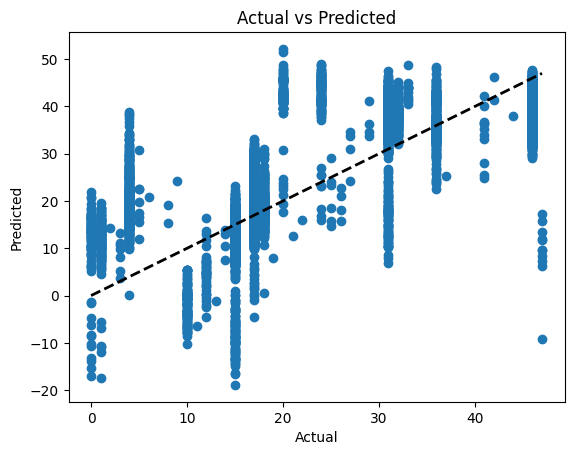

In [53]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

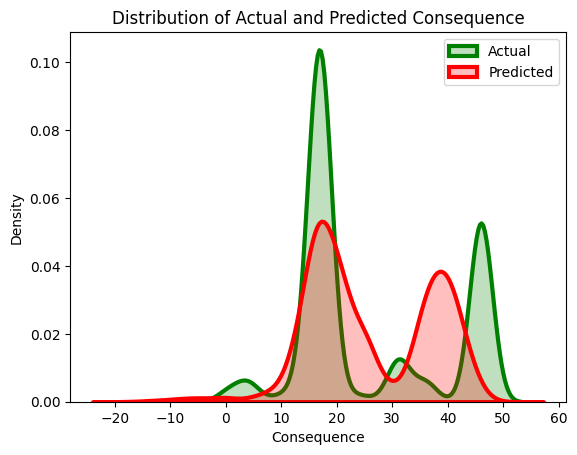

In [54]:
sns.kdeplot(y_test, label='Actual', color='g', shade=True, linewidth=3)
sns.kdeplot(y_pred, label='Predicted', color='r', shade=True, linewidth=3)
plt.xlabel('Consequence')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Consequence')
plt.legend()
plt.show()